In [ ]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [ ]:
import tensorflow
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/Shareddrives/Machine Learning Project")
!ls

'age_detection file'	  'Age Detection.pptx'	'New Code'   UTK_Face0521.csv
'age_detection file.zip'   Final_Project.ipynb	 UTKFace     ZIPPED_DATASETS


## Import data

In [ ]:
utkface_image_names = os.listdir("/content/drive/Shareddrives/Machine Learning Project/UTKFace")

## EDA

In [ ]:
def age_gender_split(image_name):
    image_labels = image_name.split('_')
    age = image_labels[0]
    gender = image_labels[1]

    return (age, gender)

In [ ]:
utkface_age_labels = np.array([])
utkface_gender_labels = np.array([])

In [ ]:
for image in utkface_image_names:
    age, gender = age_gender_split(image)
    utkface_age_labels = np.append(utkface_age_labels, age)
    utkface_gender_labels = np.append(utkface_gender_labels, gender)

In [ ]:
#! pip install pillow
from PIL import Image
filepath = "/content/drive/Shareddrives/Machine Learning Project/UTKFace/84_1_0_20170120223609069.jpg.chip.jpg"
img = Image.open(filepath)
print(img.width, img.height)

200 200


In [ ]:
utkface_age_labels = np.array([])
utkface_gender_labels = np.array([])
utkface_race_labels = np.array([])

for image in utkface_image_names:
    age, gender, race = age_gender_race_split(image)
    utkface_age_labels = np.append(utkface_age_labels, age)
    utkface_gender_labels = np.append(utkface_gender_labels, gender)
    utkface_race_labels = np.append(utkface_race_labels, race)

In [ ]:
utkface_ages_counts = pd.DataFrame(pd.Series(utkface_age_labels).value_counts())
utkface_ages_counts.reset_index(inplace=True)
utkface_ages_counts.columns = ['age','count']
utkface_ages_counts['age'] = utkface_ages_counts['age'].apply(lambda x: int(x))
utkface_ages_counts = utkface_ages_counts.sort_values(by = 'age', ascending=True)
utkface_ages_counts

,age,count
1,1,1123
12,2,482
24,3,289
26,4,273
38,5,196
...,...,...
96,105,5
95,110,5
103,111,1
99,115,3


Text(0.5, 1.0, 'Age Distribution of Images')

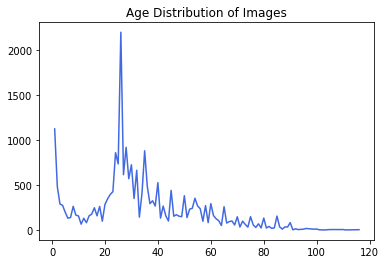

In [ ]:
plt.plot(utkface_ages_counts['age'], utkface_ages_counts['count'], color='royalblue')
plt.title('Age Distribution of Images')

In [ ]:
# Grouping by the gender labels and checking the no. of images per age label and transform it to dataframe.
# 0 = Male, 1 = Female

utkface_genders_counts = pd.DataFrame(pd.Series(utkface_gender_labels).value_counts())
utkface_genders_counts.reset_index(inplace=True)
utkface_genders_counts.columns = ['gender','count']
utkface_genders_counts['gender'] = utkface_genders_counts['gender'].apply(lambda x: 'male' if x=='0' else 'female')
utkface_genders_counts

,gender,count
0,male,12391
1,female,11317


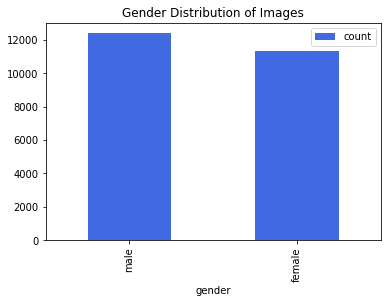

In [ ]:
utkface_genders_counts.plot.bar(x="gender", y='count', color='royalblue', title='Gender Distribution of Images')

In [ ]:
# Grouping by the race labels and checking the no. of images per race label.
# 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others (like Hispanic, Latino, Middle Eastern)
# This is just for extra info and will not be used in the model.

utkface_races_counts = pd.DataFrame(pd.Series(utkface_race_labels).value_counts())
utkface_races_counts.reset_index(inplace=True)
utkface_races_counts.columns = ['race_index','count']
utkface_races_counts.loc[utkface_races_counts['race_index']=='0', 'race'] = 'White'
utkface_races_counts.loc[utkface_races_counts['race_index']=='1', 'race'] = 'Black'
utkface_races_counts.loc[utkface_races_counts['race_index']=='2', 'race'] = 'Asian'
utkface_races_counts.loc[utkface_races_counts['race_index']=='3', 'race'] = 'Indian'
utkface_races_counts.loc[utkface_races_counts['race_index']=='4', 'race'] = 'Others'
utkface_races_counts

# 3 images don't have race labels in their file name, as seen below.

,race_index,count,race
0,0,10078,White
1,1,4526,Black
2,3,3975,Indian
3,2,3434,Asian
4,4,1692,Others
5,20170109142408075.jpg.chip.jpg,1,NaN
6,20170109150557335.jpg.chip.jpg,1,NaN
7,20170116174525125.jpg.chip.jpg,1,NaN


In [ ]:
utkface_races_counts.loc[1,'race'] = 'African'
utkface_races_counts.dropna(inplace = True)

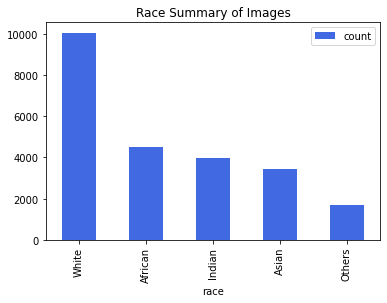

In [ ]:
utkface_races_counts.plot.bar(x="race", y='count',color='royalblue', title='Race Summary of Images')

In [ ]:
ages, counts = np.unique(utkface_age_labels, return_counts=True)
d = dict(zip(ages, counts))
d = {int(k):int(v) for k,v in d.items()}

In [ ]:
def class_labels(age):
    if 0 <= age <= 14:
        return 0
    elif 15 <= age <= 24:
        return 1
    elif 25 <= age <= 28:
        return 2
    elif 29 < age <= 33:
        return 3
    elif 34 <= age <= 45:
        return 4
    elif 46 <= age <= 60:
        return 5
    else:
        return 6


In [ ]:
age_groups_df = pd.DataFrame()

age_groups_df['filename'] = utkface_image_names
age_groups_df['age'] = age_groups_df['filename'].map(lambda img_name : np.uint8(img_name.split("_")[0]))
age_groups_df['target'] = age_groups_df['age'].map(class_labels)

In [ ]:
age_groups_df.head()

,filename,age,target
0,84_1_0_20170120223609069.jpg.chip.jpg,84,6
1,82_1_1_20170110154342872.jpg.chip.jpg,82,6
2,83_1_0_20170120230355596.jpg.chip.jpg,83,6
3,83_1_0_20170120225627516.jpg.chip.jpg,83,6
4,83_1_0_20170110181333958.jpg.chip.jpg,83,6


In [302]:
utkface_agegroups_counts = age_groups_df.groupby(['target'])['target'].count()
utkface_agegroups_counts

target
0    3650
1    3252
2    4464
3    2451
4    4277
5    3216
6    2397
Name: target, dtype: int64

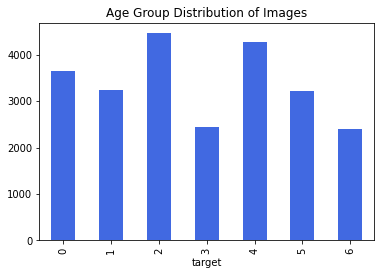

In [303]:
utkface_agegroups_counts.plot.bar(color='royalblue', title='Age Group Distribution of Images')

In [ ]:
age_groups_df['target'] = age_groups_df['target'].map(str)

## Train test split

In [ ]:
# exclude image file that cannot identified
age_groups_df = age_groups_df[age_groups_df.filename != '10_1_2_20170104005417671.jpg.chip.jpg']
age_groups_df.reset_index(inplace = True)
age_groups_df.drop('index', axis = 1, inplace = True)
age_groups_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,filename,age,target
0,84_1_0_20170120223609069.jpg.chip.jpg,84,6
1,82_1_1_20170110154342872.jpg.chip.jpg,82,6
2,83_1_0_20170120230355596.jpg.chip.jpg,83,6
3,83_1_0_20170120225627516.jpg.chip.jpg,83,6
4,83_1_0_20170110181333958.jpg.chip.jpg,83,6


In [ ]:
def train_test_split(df, test_percent, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_percent = 1 - test_percent
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [ ]:
train_df, test_df = train_test_split(age_groups_df, test_percent = 0.3, seed=0)

## Generate train and test data

In [ ]:
# !pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.


In [ ]:
from keras.preprocessing import image

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2)

In [ ]:
train_generator_new = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/content/drive/Shareddrives/Machine Learning Project/UTKFace/",
    x_col='filename',
    y_col='target',
    target_size=(136, 136),
    color_mode="rgb",
    batch_size=32,   
    class_mode="categorical",
    seed = 74
)

Found 16594 validated image filenames belonging to 7 classes.


In [ ]:
test_generator_new = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/drive/Shareddrives/Machine Learning Project/UTKFace/",
    x_col='filename',
    y_col='target',
    target_size=(136, 136),
    color_mode="rgb",
    batch_size=32,   
    class_mode="categorical",
    seed = 74
)

Found 7113 validated image filenames belonging to 7 classes.


In [ ]:
X_train, y_train = next(train_generator_new)
X_test, y_test = next(test_generator_new)

## Transfer Learning using InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
pretrained_inceptionV3 = InceptionV3(input_shape = (136, 136, 3), include_top = False, weights = "imagenet")

In [ ]:
pretrained_inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 136, 136, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 67, 67, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 67, 67, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
# unfreeze the last 12 layers
for layer in pretrained_inceptionV3.layers[-12:]:
  layer.trainable = False

In [ ]:
x = pretrained_inceptionV3.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(7, activation="softmax")(x)

model = Model(pretrained_inceptionV3.input, predictions)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 136, 136, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 67, 67, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 67, 67, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# callbacks = Callback()

history = model.fit(train_generator_new, steps_per_epoch = 20, epochs = 60, verbose = 2) # 60 epochs

Epoch 1/60
20/20 - 153s - loss: 2.1296 - accuracy: 0.2422 - 153s/epoch - 8s/step
Epoch 2/60
20/20 - 131s - loss: 1.8661 - accuracy: 0.2750 - 131s/epoch - 7s/step
Epoch 3/60
20/20 - 135s - loss: 1.7048 - accuracy: 0.3453 - 135s/epoch - 7s/step
Epoch 4/60
20/20 - 137s - loss: 1.6044 - accuracy: 0.3703 - 137s/epoch - 7s/step
Epoch 5/60
20/20 - 134s - loss: 1.6869 - accuracy: 0.3219 - 134s/epoch - 7s/step
Epoch 6/60
20/20 - 137s - loss: 1.5457 - accuracy: 0.3781 - 137s/epoch - 7s/step
Epoch 7/60
20/20 - 136s - loss: 1.5148 - accuracy: 0.4062 - 136s/epoch - 7s/step
Epoch 8/60
20/20 - 133s - loss: 1.5595 - accuracy: 0.3844 - 133s/epoch - 7s/step
Epoch 9/60
20/20 - 132s - loss: 1.5130 - accuracy: 0.3719 - 132s/epoch - 7s/step
Epoch 10/60
20/20 - 131s - loss: 1.4877 - accuracy: 0.3922 - 131s/epoch - 7s/step
Epoch 11/60
20/20 - 132s - loss: 1.5272 - accuracy: 0.3750 - 132s/epoch - 7s/step
Epoch 12/60
20/20 - 129s - loss: 1.4608 - accuracy: 0.3984 - 129s/epoch - 6s/step
Epoch 13/60
20/20 - 130s 

In [ ]:
# save model
model.save('/content/drive/MyDrive/transfer_InceptionV3_unfreeze_model.h5')
print("Saved model")

Saved model


## Get model evaluation

In [293]:
history.history['accuracy'][-1]

0.4749999940395355

In [288]:
evaluation = model.evaluate(test_generator_new, batch_size=32)
print("test loss, test acc:", evaluation)

223/223 [==============================] - 262s 1s/step - loss: 3.0538 - accuracy: 0.3958
test loss, test acc: [3.0537807941436768, 0.39575424790382385]


In [252]:
model.predict_generator(test_generator_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([[7.13651767e-03, 6.62179058e-03, 1.98828094e-02, ...,
        2.22778708e-01, 4.45747703e-01, 2.59798855e-01],
       [1.08393212e-03, 3.81600410e-02, 2.45611429e-01, ...,
        4.41434622e-01, 9.40145329e-02, 1.18970433e-02],
       [2.49409676e-03, 2.89540533e-02, 1.60721526e-01, ...,
        4.50115502e-01, 1.67484269e-01, 3.36368978e-02],
       ...,
       [1.51579119e-02, 2.79960856e-02, 7.63001665e-02, ...,
        3.29369515e-01, 3.26259702e-01, 1.26709223e-01],
       [1.97798153e-03, 1.05986014e-01, 3.71883631e-01, ...,
        3.03004473e-01, 4.65413444e-02, 4.25463729e-03],
       [2.37778630e-04, 6.56672796e-07, 4.62225330e-07, ...,
        1.00186051e-04, 8.84443242e-03, 9.90814865e-01]], dtype=float32)

In [296]:
# import some stuff
import plotly.express as px
from plotly.subplots import make_subplots

df = history.history

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(df, y=df['accuracy'], render_mode="webgl",)
fig2 = px.line(df,  y=df['loss'], render_mode="webgl",)

fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title="epochs"
subfig.layout.yaxis.title="Accuracy"
subfig.layout.yaxis2.title="Loss"
# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()